BDA PROJECT CODE. We will start with initializing session, reading data, data preprocessing, EDA, feature engineering, modeling and result analysis.

In [1]:
!pip install pyspark

In [2]:
# importing necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, to_date, datediff, count, avg
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# initialize spark session
spark = SparkSession.builder \
    .appName("Efficient Supply Chain Management") \
    .getOrCreate()
# Install gdown
!pip install gdown

# Import gdown
import gdown

# URL with the file ID
url = 'https://drive.google.com/uc?id=1Gg_3aadbv6LBQLyHwQELjyVGTodD3VJB'

output = 'supplychaindata.csv'
# Download the file
gdown.download(url, output, quiet=False)

# load the dataset
#data_path = '/content/drive/my-drive/Supply_Chain_data.csv'
data = spark.read.csv('supplychaindata.csv', header=True, inferSchema=True)

# inspecting the data schema
data.printSchema()

Downloading...
From: https://drive.google.com/uc?id=1Gg_3aadbv6LBQLyHwQELjyVGTodD3VJB
To: /content/supplychaindata.csv
100%|██████████| 3.82M/3.82M [00:00<00:00, 26.6MB/s]


root
 |-- id: integer (nullable = true)
 |-- project code: string (nullable = true)
 |-- pq #: string (nullable = true)
 |-- po / so #: string (nullable = true)
 |-- asn/dn #: string (nullable = true)
 |-- country: string (nullable = true)
 |-- managed by: string (nullable = true)
 |-- fulfill via: string (nullable = true)
 |-- vendor inco term: string (nullable = true)
 |-- shipment mode: string (nullable = true)
 |-- pq first sent to client date: string (nullable = true)
 |-- po sent to vendor date: string (nullable = true)
 |-- scheduled delivery date: string (nullable = true)
 |-- delivered to client date: string (nullable = true)
 |-- delivery recorded date: string (nullable = true)
 |-- product group: string (nullable = true)
 |-- sub classification: string (nullable = true)
 |-- vendor: string (nullable = true)
 |-- item description: string (nullable = true)
 |-- molecule/test type: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- dosage: string (nullable = tru

### EDA & Data Preprocessing

In [3]:
# this step comprises of handling NAs and converting columns to the right datatype
from pyspark.sql.functions import col, when, regexp_extract, to_date, lit, datediff, avg, count
from pyspark.sql.types import DoubleType, IntegerType

# handling missing values
data = data.fillna({
    "shipment mode": "Unknown",  # Fill missing categorical values
    "line item insurance (usd)": 0.0  # Fill missing numerical values
})

# standardizing data types
# converting columns to appropriate types

data = data.withColumn("weight (kilograms)", col("weight (kilograms)").cast(DoubleType()))
data = data.withColumn("freight cost (usd)", col("freight cost (usd)").cast(DoubleType()))
data = data.withColumn("line item value", col("line item value").cast(DoubleType()))
data = data.withColumn("line item quantity", col("line item quantity").cast(IntegerType()))


In [4]:
data.show(10)

+---+------------+--------------+---------+--------+-------------+----------+-----------+----------------+-------------+----------------------------+----------------------+-----------------------+------------------------+----------------------+-------------+------------------+--------------------+--------------------+--------------------+---------------+--------+---------------+--------------------------+------------------+---------------+----------+----------+--------------------+----------------------+------------------+------------------+-------------------------+
| id|project code|          pq #|po / so #|asn/dn #|      country|managed by|fulfill via|vendor inco term|shipment mode|pq first sent to client date|po sent to vendor date|scheduled delivery date|delivered to client date|delivery recorded date|product group|sub classification|              vendor|    item description|  molecule/test type|          brand|  dosage|    dosage form|unit of measure (per pack)|line item quantity

In [5]:
# This is to remove whitespace in the dated columns
from pyspark.sql.functions import col, to_date, trim

# list of date columns
date_columns = ["pq first sent to client date", "po sent to vendor date", "scheduled delivery date", "delivered to client date", "delivery recorded date"]

for col_name in date_columns:
    data = data.withColumn(
        col_name,
        to_date(trim(col(col_name)), "d-MMM-yy")  #trimmed whitespaces and parsed date
    )


In [6]:
data.show() # current date format yyyy-MM-dd

+-----+------------+--------------+-----------+---------+-------------+----------+-----------+----------------+-------------+----------------------------+----------------------+-----------------------+------------------------+----------------------+-------------+------------------+--------------------+--------------------+--------------------+---------------+---------+--------------------+--------------------------+------------------+---------------+----------+----------+--------------------+----------------------+------------------+------------------+-------------------------+
|   id|project code|          pq #|  po / so #| asn/dn #|      country|managed by|fulfill via|vendor inco term|shipment mode|pq first sent to client date|po sent to vendor date|scheduled delivery date|delivered to client date|delivery recorded date|product group|sub classification|              vendor|    item description|  molecule/test type|          brand|   dosage|         dosage form|unit of measure (per pa

In [7]:
data.select("scheduled delivery date").show(10)

+-----------------------+
|scheduled delivery date|
+-----------------------+
|             2006-06-02|
|             2006-11-14|
|             2006-08-27|
|             2006-09-01|
|             2006-08-11|
|             2006-09-28|
|             2007-01-08|
|             2006-11-24|
|             2006-12-07|
|             2007-01-30|
+-----------------------+
only showing top 10 rows



In [11]:
from pyspark.sql.functions import col, date_sub

# updated 'pq first sent to client date' to be 60 days before 'scheduled delivery date' as majority of it was given as pre pq process
# and also we had a few dates which had a 2 month gap, further the shipping is done outside of the country
# so we took an estimate of 2 months for delivery

data = data.withColumn(
    "pq first sent to client date",
    date_sub(col("scheduled delivery date"), 60)
)

In [12]:
from pyspark.sql.functions import col, date_sub

# updated 'po sent to vendor date' to be 45 days before 'scheduled delivery date'
# same reasoning further a few dates showed around 42-45 days difference

data = data.withColumn(
    "po sent to vendor date",
    date_sub(col("scheduled delivery date"), 45)
)

In [13]:
data.show(10, truncate=False)

+---+------------+--------------+---------+--------+-------------+----------+-----------+----------------+-------------+----------------------------+----------------------+-----------------------+------------------------+----------------------+-------------+------------------+-----------------------------------------------------------------+--------------------------------------------------------+----------------------------------------+---------------+--------+---------------+--------------------------+------------------+---------------+----------+----------+------------------------------+----------------------+------------------+------------------+-------------------------+
|id |project code|pq #          |po / so #|asn/dn #|country      |managed by|fulfill via|vendor inco term|shipment mode|pq first sent to client date|po sent to vendor date|scheduled delivery date|delivered to client date|delivery recorded date|product group|sub classification|vendor                                

In [14]:
from pyspark.sql.functions import col, sum

# calculating the number of nulls for each column
null_counts = data.select([(sum(col(c).isNull().cast("int")).alias(c)) for c in data.columns])

null_counts.show()


+---+------------+----+---------+--------+-------+----------+-----------+----------------+-------------+----------------------------+----------------------+-----------------------+------------------------+----------------------+-------------+------------------+------+----------------+------------------+-----+------+-----------+--------------------------+------------------+---------------+----------+----------+------------------+----------------------+------------------+------------------+-------------------------+
| id|project code|pq #|po / so #|asn/dn #|country|managed by|fulfill via|vendor inco term|shipment mode|pq first sent to client date|po sent to vendor date|scheduled delivery date|delivered to client date|delivery recorded date|product group|sub classification|vendor|item description|molecule/test type|brand|dosage|dosage form|unit of measure (per pack)|line item quantity|line item value|pack price|unit price|manufacturing site|first line designation|weight (kilograms)|freigh

In [15]:
# based on the values given by our null counts, we need to ensure that there are no nulls and impute logically based on what the column comprises of
from pyspark.sql.functions import col, lit, when, percentile_approx, to_date, trim
from pyspark.sql.types import DoubleType, IntegerType

# drop the 'line item insurance (usd)' column
data = data.drop("line item insurance (usd)")

# handling missing values for categorical columns
categorical_imputations = {
    "shipment mode": None,  # filled dynamically using mode
    "vendor": None,  # filled dynamically using mode
    "dosage": "Not Specified",
    "brand": "Generic",
    "product group": "Other",
    "sub classification": "Other",
    "manufacturing site": "Unknown"
}

# dynamically calculate the mode for specific categorical columns
for col_name in ["shipment mode", "vendor"]:
    mode_value = data.groupBy(col_name).count().orderBy(col("count").desc()).first()[col_name]
    categorical_imputations[col_name] = mode_value

# applying the imputations for categorical columns
data = data.fillna(categorical_imputations)

# imputed numerical columns with median values
numeric_columns = ["unit of measure (per pack)", "line item quantity", "line item value",
                   "pack price", "unit price", "weight (kilograms)", "freight cost (usd)"]

for col_name in numeric_columns:
    median_value = data.select(percentile_approx(col_name, 0.5).alias("median")).collect()[0]["median"]
    data = data.withColumn(
        col_name,
        when(col(col_name).isNull(), lit(median_value)).otherwise(col(col_name))
    )

# checking again for nulls
null_counts = data.select([(sum(col(c).isNull().cast("int")).alias(c)) for c in data.columns])

null_counts.show()

+---+------------+----+---------+--------+-------+----------+-----------+----------------+-------------+----------------------------+----------------------+-----------------------+------------------------+----------------------+-------------+------------------+------+----------------+------------------+-----+------+-----------+--------------------------+------------------+---------------+----------+----------+------------------+----------------------+------------------+------------------+
| id|project code|pq #|po / so #|asn/dn #|country|managed by|fulfill via|vendor inco term|shipment mode|pq first sent to client date|po sent to vendor date|scheduled delivery date|delivered to client date|delivery recorded date|product group|sub classification|vendor|item description|molecule/test type|brand|dosage|dosage form|unit of measure (per pack)|line item quantity|line item value|pack price|unit price|manufacturing site|first line designation|weight (kilograms)|freight cost (usd)|
+---+-------

In [16]:
# create the delay_status column, this is a derived column that shows if the delivery was delayed or not
from pyspark.sql.functions import when, col, datediff

# creating the 'delay_status' column
data = data.withColumn(
    "delay_status",
    when(datediff(col("delivered to client date"), col("scheduled delivery date")) > 0, 1).otherwise(0)
)

# checking the distribution of delayed and on-time deliveries
data.groupBy("delay_status").count().show()



+------------+-----+
|delay_status|count|
+------------+-----+
|           1| 1186|
|           0| 9138|
+------------+-----+



In [17]:
# days_of_delay is our continuous target var, we are categorizing the extent of delay which is our main target to be predicted for delay prediction
from pyspark.sql.functions import datediff

# created a continuous target variable: days_of_delay
data = data.withColumn(
    "days_of_delay",
    datediff(col("`delivered to client date`"), col("`scheduled delivery date`"))
)

# created the shipping_duration column
from pyspark.sql.functions import datediff

data = data.withColumn(
    "shipping_duration",
    datediff(col("delivered to client date"), col("scheduled delivery date"))
)

data = data.withColumn(
    "lead_time",
    datediff(col("scheduled delivery date"), col("po sent to vendor date"))
)

data = data.withColumn(
    "delay_category",
    when(col("days_of_delay") < -10, "Early")
    .when((col("days_of_delay") >= -10) & (col("days_of_delay") <= 5), "On Time")
    .when((col("days_of_delay") > 5) & (col("days_of_delay") <= 30), "Moderate Delay")
    .otherwise("Severe Delay")
)

# count the number of rows in each delay category
data.groupBy("delay_category").count().show()

# analyzing shipment mode distribution
data.groupBy("shipment mode", "delay_category").count().show()

+--------------+-----+
|delay_category|count|
+--------------+-----+
|       On Time| 7506|
|         Early| 1945|
|Moderate Delay|  643|
|  Severe Delay|  230|
+--------------+-----+

+-------------+--------------+-----+
|shipment mode|delay_category|count|
+-------------+--------------+-----+
|        Truck|Moderate Delay|  278|
|        Truck|  Severe Delay|   72|
|          Air|Moderate Delay|  298|
|      Unknown|       On Time|  331|
|  Air Charter|         Early|  350|
|  Air Charter|       On Time|  256|
|          Air|         Early|  770|
|          Air|  Severe Delay|  116|
|      Unknown|  Severe Delay|    1|
|        Truck|         Early|  788|
|  Air Charter|Moderate Delay|   39|
|        Ocean|         Early|   10|
|          Air|       On Time| 4929|
|        Ocean|       On Time|  298|
|        Ocean|Moderate Delay|   27|
|      Unknown|         Early|   27|
|  Air Charter|  Severe Delay|    5|
|        Ocean|  Severe Delay|   36|
|      Unknown|Moderate Delay|    1|
|

#### Visualizations

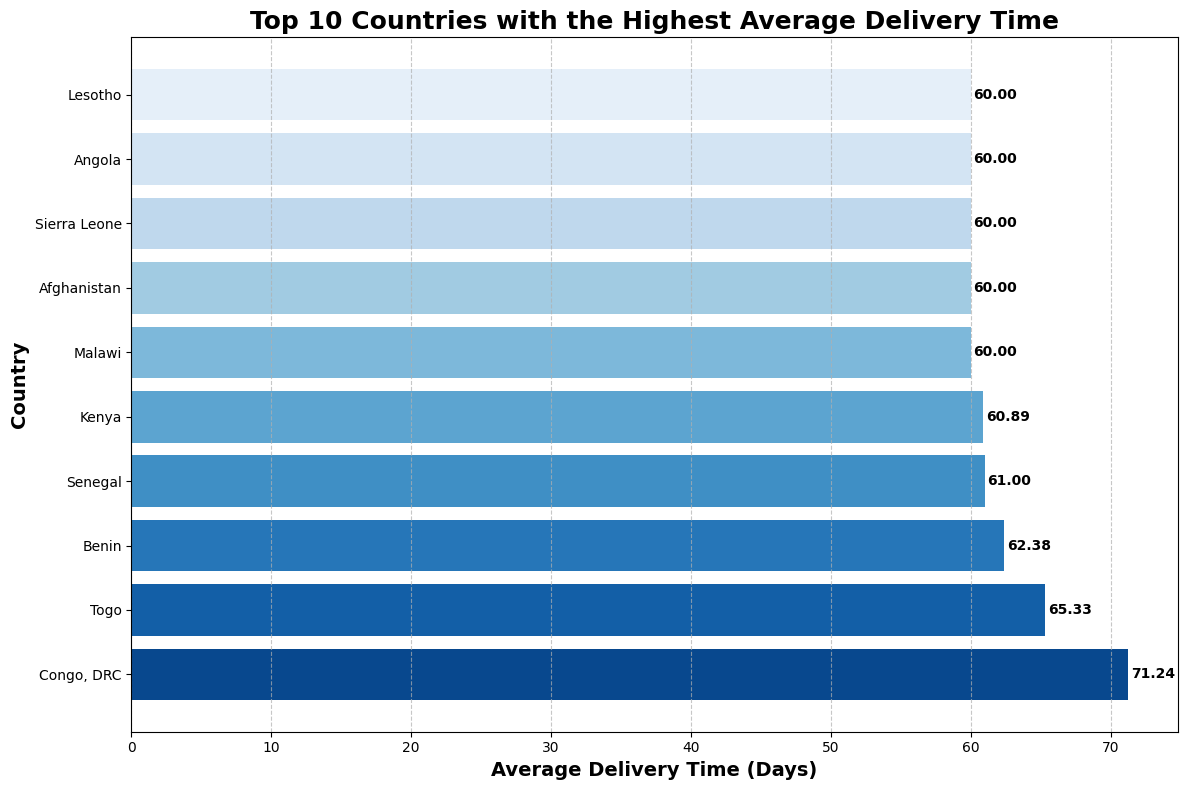

In [18]:
from pyspark.sql.functions import col, datediff, avg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# calculate the delivery time (in days)
delivery_time_df = data.withColumn(
    "delivery_time_days",
    datediff(col("delivered to client date"), col("pq first sent to client date"))
).groupBy("country").agg(avg("delivery_time_days").alias("avg_delivery_time"))

# get top 10 countries with the highest average delivery time
top_10_delivery_time_df = delivery_time_df.orderBy(col("avg_delivery_time"), ascending=False).limit(10)

# converting the results to a Pandas DataFrame for visualization
top_10_delivery_time_pd = top_10_delivery_time_df.toPandas()

# plot bar chart with enhanced styling
plt.figure(figsize=(12, 8))

# applying a color palette
sns.set_palette("pastel")

# create horizontal bars with seaborn color palette
bars = plt.barh(top_10_delivery_time_pd["country"], top_10_delivery_time_pd["avg_delivery_time"], color=sns.color_palette("Blues_r", n_colors=10))

# added value labels to bars for clarity
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.2, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', va='center', ha='left', color='black', fontweight='bold')

plt.title("Top 10 Countries with the Highest Average Delivery Time", fontsize=18,fontweight ='bold', color='black')
plt.xlabel("Average Delivery Time (Days)", fontsize=14, fontweight='bold')
plt.ylabel("Country", fontsize=14, fontweight='bold')

plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


<ipython-input-19-8b687b239295>:13: UserWarning: 
The markers list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


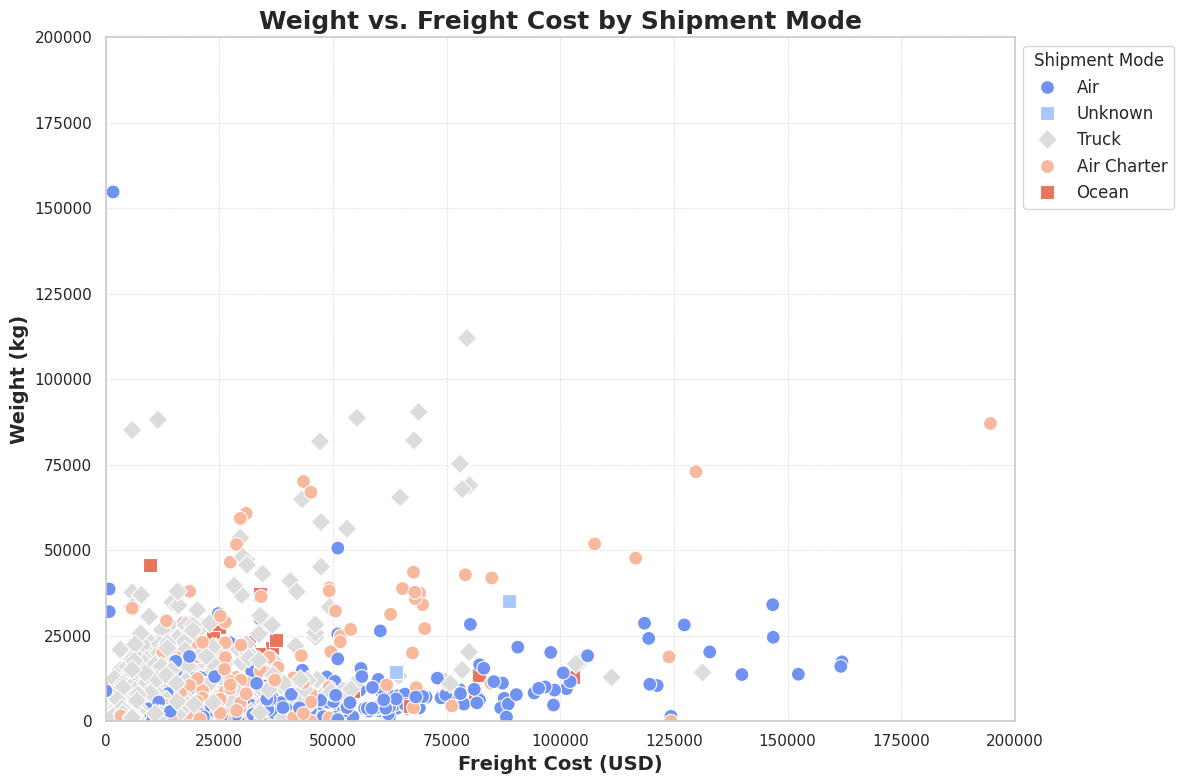

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# selected relevant columns and convert to Pandas DataFrame
weight_freight_pd = data.select("weight (kilograms)", "freight cost (usd)", "shipment mode").toPandas()

sns.set(style="whitegrid", palette="muted")

# scatter plot of weight vs freight cost with better styling
plt.figure(figsize=(12, 8))

# using a scatter plot with a clear distinction of 'shipment mode' via colors and markers
sns.scatterplot(
    data=weight_freight_pd,
    x="freight cost (usd)",
    y="weight (kilograms)",
    hue="shipment mode",
    palette="coolwarm",
    style="shipment mode",
    markers=["o", "s", "D"],
    s=100,
    edgecolor='w',
    legend="full"
)


plt.title("Weight vs. Freight Cost by Shipment Mode", fontsize=18, fontweight='bold')

# Labels with increased font size and bold styling
plt.xlabel("Freight Cost (USD)", fontsize=14, fontweight='bold')
plt.ylabel("Weight (kg)", fontsize=14, fontweight='bold')


plt.legend(title="Shipment Mode", loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)


plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.xlim(0, 200000)  # set x-axis limit for Freight Cost
plt.ylim(0, 200000)  # set y-axis limit for Weight


plt.tight_layout()


plt.show()


In [20]:
import plotly.express as px

# Aggregated the total line item value by country
country_value_df = data.groupBy("country").sum("line item value").withColumnRenamed("sum(line item value)", "total_value")

# Convert to pandas DataFrame for plotly
country_value_pd = country_value_df.toPandas()

# Ensuring that country names are in the correct format (e.g., no extra spaces, case normalization)
country_value_pd['country'] = country_value_pd['country'].str.strip().str.title()

# Plot a choropleth map with improved visualizations
fig = px.choropleth(
    country_value_pd,
    locations="country",
    locationmode="country names",  # Ensuring the country names are correctly matched
    color="total_value",
    color_continuous_scale=px.colors.sequential.Plasma,  # More visually appealing color scale
    labels={'total_value': 'Total Line Item Value (USD)'},
    title="Total Line Item Value by Country",
    template="plotly",  # White background for better visibility
    width=1200,  # Increased width for a larger map
    height=1000  # Increased height for a larger map
)

# Update geos for better appearance
fig.update_geos(
    showcoastlines=True,
    coastlinecolor="Black",
    projection_type="natural earth",  # Use a nice natural earth projection
    showland=True,
    landcolor="white",
)

# Adjust layout scale and legend position
fig.update_layout(
    coloraxis_colorbar=dict(
        len=0.6,  # Adjusted length of the color bar
        thickness=15,  # Thinner color bar for a smaller legend
        xanchor="right",  # Align the legend closer to the right edge
        x=1.2,  # Move it further to the right side of the map
    ),
    margin={"r":0, "l":0, "b":0, "t":40}  # Reduced margins for better map coverage
)

fig.show()


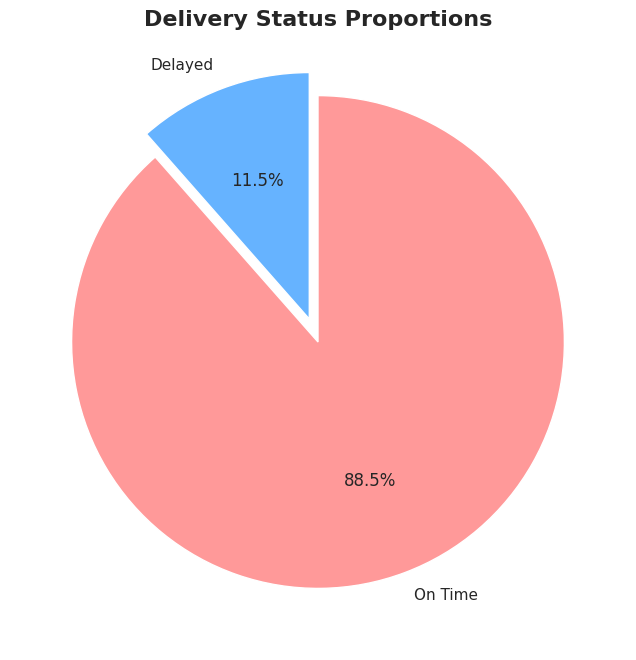

In [21]:
import matplotlib.pyplot as plt

# aggregated counts for delayed and on-time deliveries
delay_status_counts = data.groupBy("delay_status").count().toPandas()

# mapped delay_status to readable labels
delay_status_counts["status"] = delay_status_counts["delay_status"].map({0: "On Time", 1: "Delayed"})

# plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    delay_status_counts["count"],
    labels=delay_status_counts["status"],
    autopct='%1.1f%%',
    colors=["#66B3FF", "#FF9999"],
    startangle=90,
    explode=(0.1, 0)
)


plt.title("Delivery Status Proportions", fontsize=16, fontweight="bold")
plt.show()


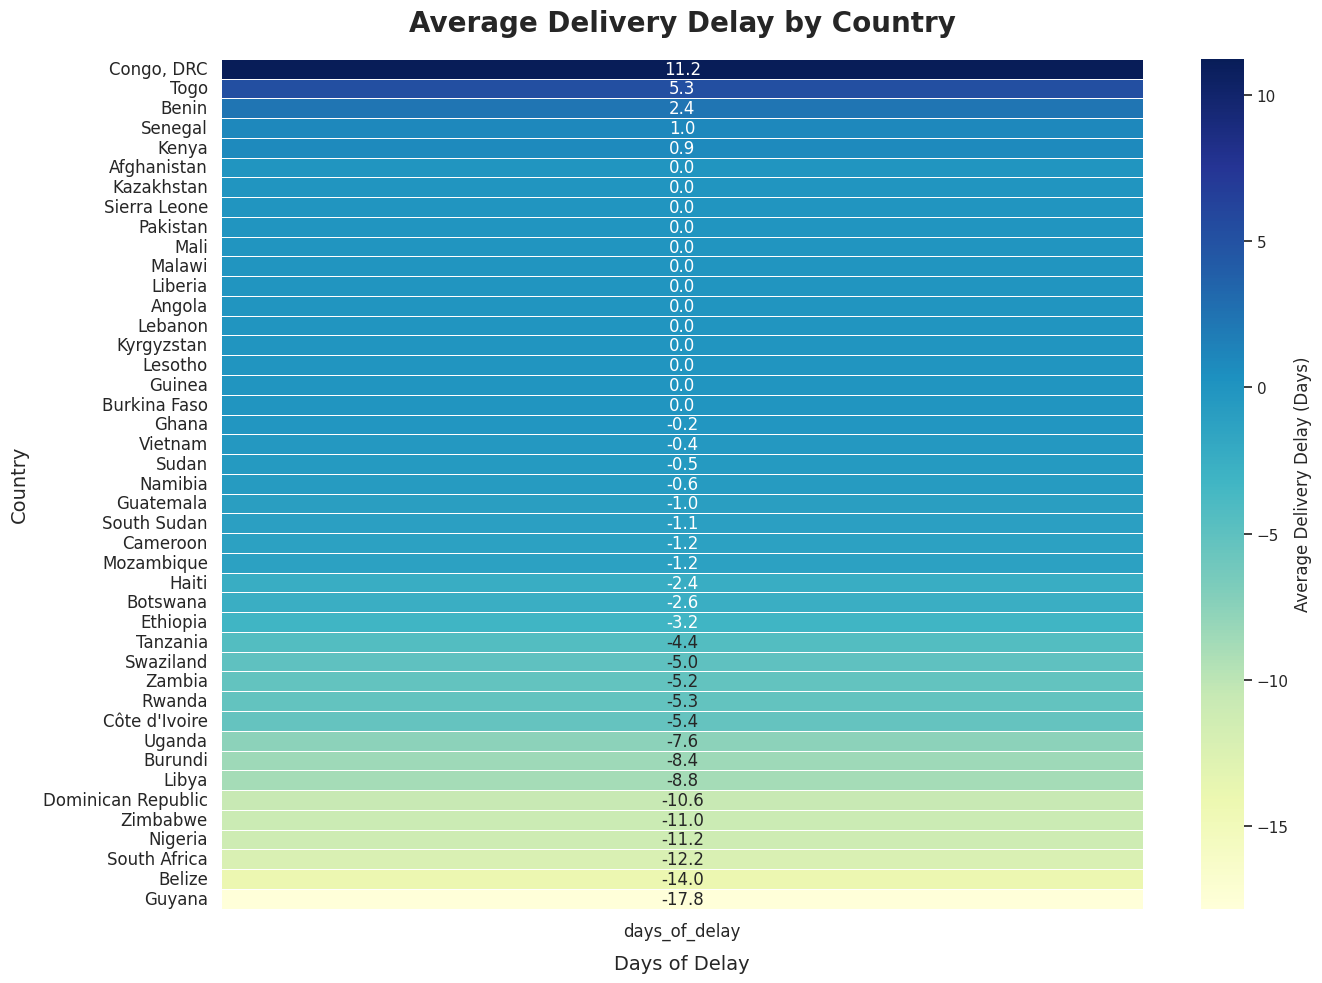

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the data to a Pandas DataFrame
df = data.toPandas()

# Prepare the pivot table
delay_by_country = df.groupby('country')['days_of_delay'].mean().reset_index()
pivot_df = delay_by_country.pivot_table(index='country', values='days_of_delay', aggfunc='mean')

# Sort countries by delay for better comparison
pivot_df = pivot_df.sort_values(by='days_of_delay', ascending=False)

# Create heatmap
plt.figure(figsize=(14, 10))
heatmap = sns.heatmap(
    pivot_df,
    annot=True,
    fmt='.1f',
    cmap='YlGnBu',
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Average Delivery Delay (Days)', 'orientation': 'vertical'}
)

# Set titles and labels
heatmap.set_title('Average Delivery Delay by Country', fontsize=20, fontweight='bold', pad=20)
heatmap.set_xlabel('')  # Remove the default x-label
heatmap.set_ylabel('Country', fontsize=14, labelpad=10)
plt.xlabel('Days of Delay', fontsize=14, labelpad=10)  # Explicitly set "Days of Delay" as the x-label

# Adjust tick label size for readability
heatmap.tick_params(axis='y', labelsize=12)
heatmap.tick_params(axis='x', labelsize=12)

# Improve layout
plt.tight_layout()
plt.show()


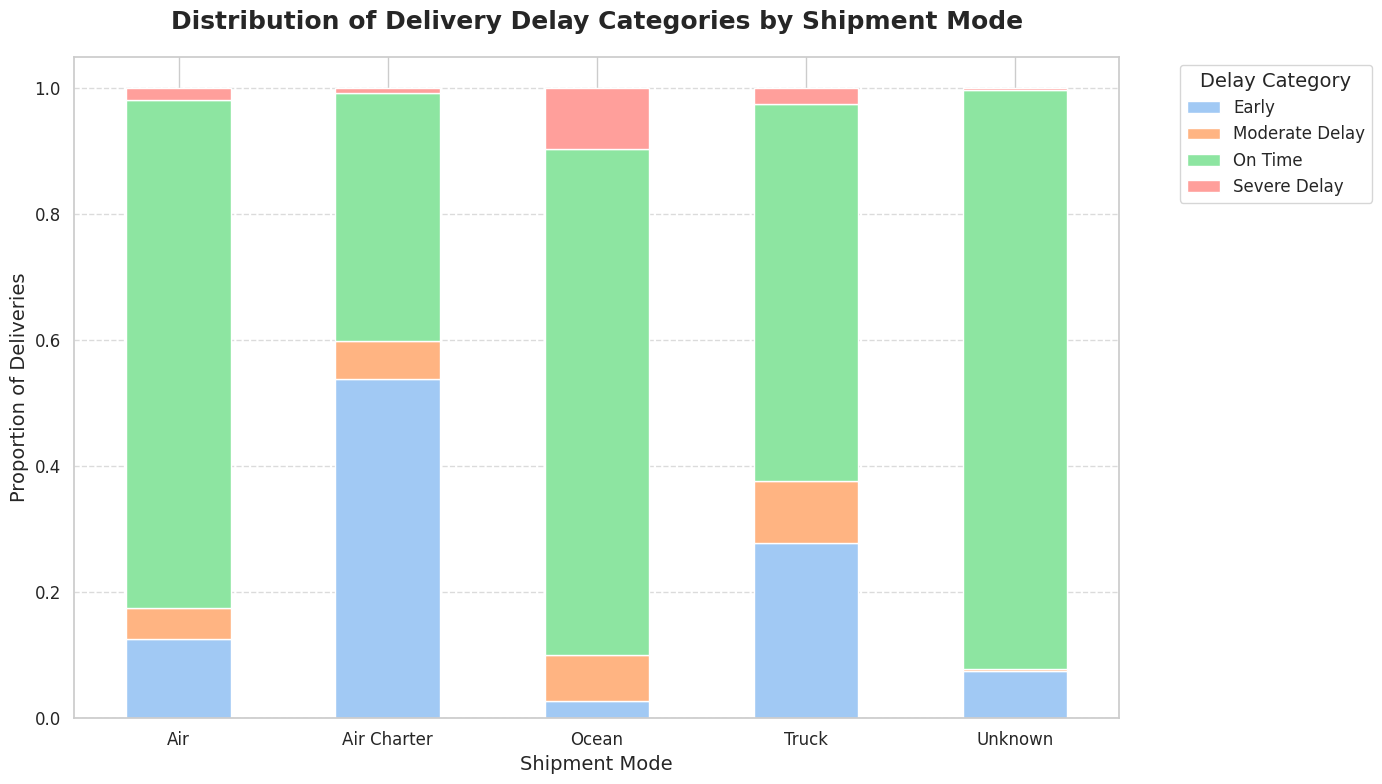

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# grouped data to calculate the counts of each delay category per shipment mode
category_counts = df.groupby(['shipment mode', 'delay_category']).size().unstack(fill_value=0)

# normalized the data to get proportions
category_proportions = category_counts.div(category_counts.sum(axis=1), axis=0)


palette = sns.color_palette("pastel", n_colors=len(category_proportions.columns))

# plot the stacked bar chart
ax = category_proportions.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    color=palette
)

plt.title('Distribution of Delivery Delay Categories by Shipment Mode', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Shipment Mode', fontsize=14)
plt.ylabel('Proportion of Deliveries', fontsize=14)


plt.legend(title='Delay Category', fontsize=12, title_fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()


plt.show()


In [24]:
data.show(5)

+---+------------+--------------+---------+--------+-------------+----------+-----------+----------------+-------------+----------------------------+----------------------+-----------------------+------------------------+----------------------+-------------+------------------+--------------------+--------------------+--------------------+---------+-------------+---------------+--------------------------+------------------+---------------+----------+----------+--------------------+----------------------+------------------+------------------+------------+-------------+-----------------+---------+--------------+
| id|project code|          pq #|po / so #|asn/dn #|      country|managed by|fulfill via|vendor inco term|shipment mode|pq first sent to client date|po sent to vendor date|scheduled delivery date|delivered to client date|delivery recorded date|product group|sub classification|              vendor|    item description|  molecule/test type|    brand|       dosage|    dosage form|uni

FEATURE ANALYSIS

In [ ]:
print(data.columns)


['id', 'project code', 'pq #', 'po / so #', 'asn/dn #', 'country', 'managed by', 'fulfill via', 'vendor inco term', 'shipment mode', 'pq first sent to client date', 'po sent to vendor date', 'scheduled delivery date', 'delivered to client date', 'delivery recorded date', 'product group', 'sub classification', 'vendor', 'item description', 'molecule/test type', 'brand', 'dosage', 'dosage form', 'unit of measure (per pack)', 'line item quantity', 'line item value', 'pack price', 'unit price', 'manufacturing site', 'first line designation', 'weight (kilograms)', 'freight cost (usd)', 'delay_status', 'days_of_delay', 'shipping_duration', 'lead_time', 'delay_category']


Let's start with some statistical analyses to fix our feature set that we will be using for the modeling. We will do ANOVA to analyze the interaction and relationship in the numerical columns.

In [25]:
from pyspark.sql.functions import col
from scipy.stats import f_oneway

# Convert PySpark DataFrame to Pandas for ANOVA
data_pd = data.select(
    "delay_category",
    "weight (kilograms)", "freight cost (usd)",
    "line item quantity", "line item value",
    "pack price", "unit price"
).toPandas()

# Perform ANOVA for each feature
anova_results = {}
for feature in ["weight (kilograms)", "freight cost (usd)", "line item quantity", "line item value", "pack price", "unit price"]:
    feature_groups = [
        data_pd[data_pd["delay_category"] == category][feature].dropna()
        for category in data_pd["delay_category"].unique()
    ]
    f_stat, p_value = f_oneway(*feature_groups)
    anova_results[feature] = {"F-statistic": f_stat, "P-value": p_value}

print(anova_results)


{'weight (kilograms)': {'F-statistic': 9.463773979047298, 'P-value': 3.0612079065002523e-06}, 'freight cost (usd)': {'F-statistic': 10.459297167451657, 'P-value': 7.237180426706725e-07}, 'line item quantity': {'F-statistic': 77.40293389571296, 'P-value': 1.6495057598070585e-49}, 'line item value': {'F-statistic': 41.13074087015738, 'P-value': 2.0566003821847483e-26}, 'pack price': {'F-statistic': 89.16011794908844, 'P-value': 5.874993057848988e-57}, 'unit price': {'F-statistic': 20.41704240621616, 'P-value': 3.467117118362918e-13}}


Excluding pq_to_po_days due to lack of variability (stddev=0.0)
Excluding po_to_scheduled_days due to lack of variability (stddev=0.0)


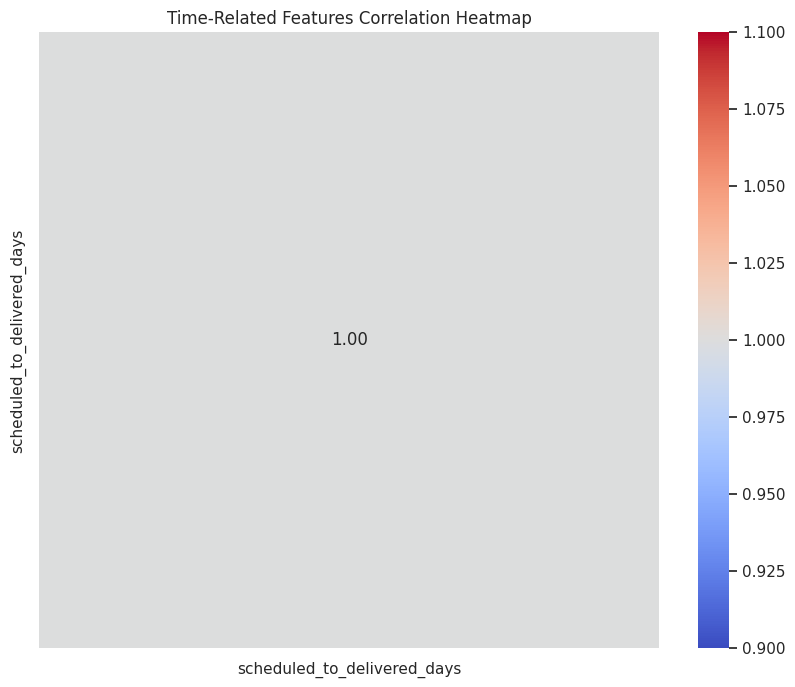

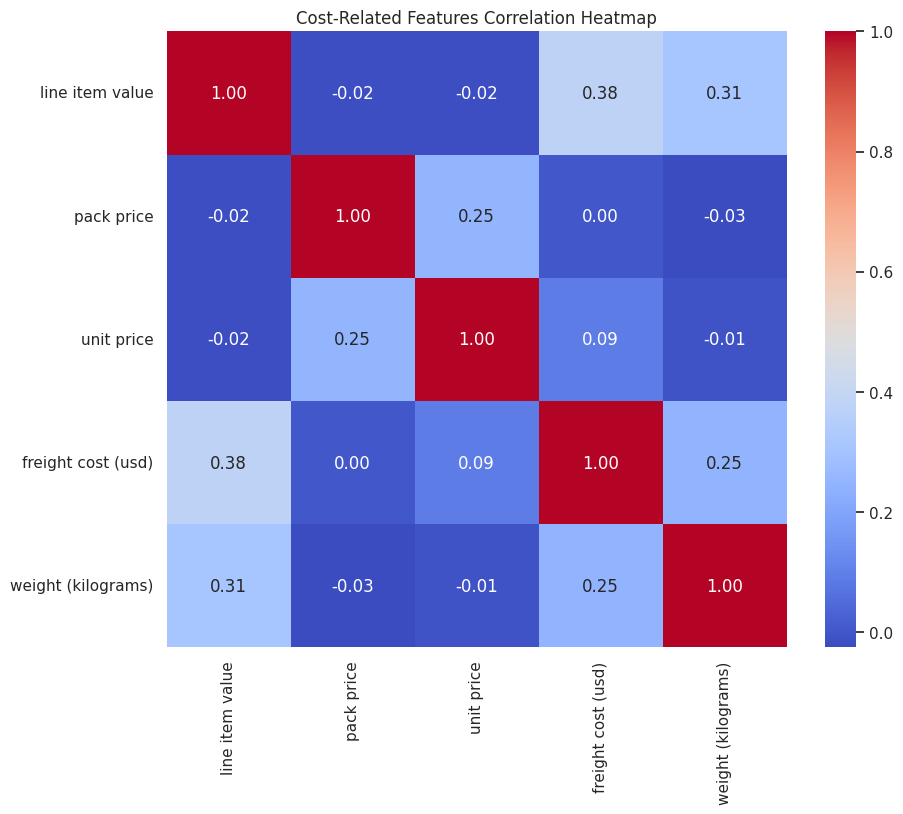

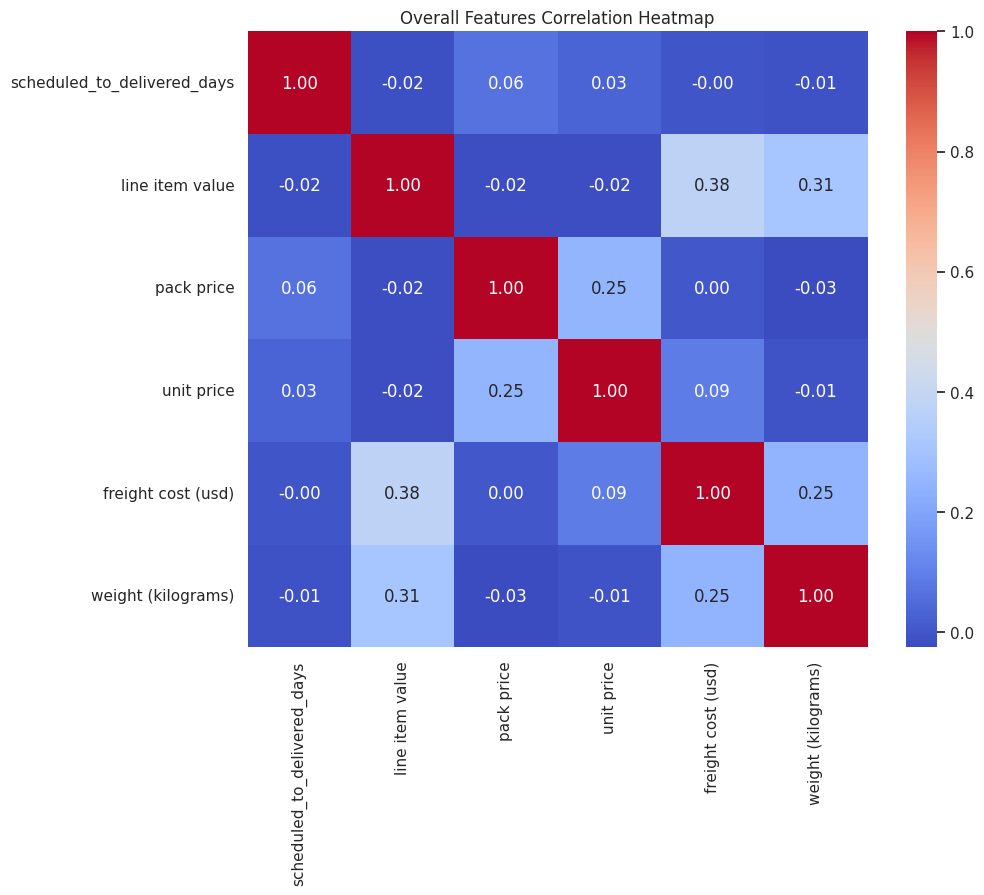

In [26]:
# Now, this is correlation. This is important because this will talk about variables and their relationship and also variability. So we will first categorize the features into groups based on their characteristics. We will view them as heatmaps
from pyspark.sql.functions import to_date, datediff, corr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert date columns to DateType
date_columns = [
    "pq first sent to client date",
    "po sent to vendor date",
    "scheduled delivery date",
    "delivered to client date",
]

for date_col in date_columns:
    data = data.withColumn(date_col, to_date(col(date_col), "yyyy-MM-dd"))

#  Create derived columns for time differences
data = data.withColumn(
    "pq_to_po_days",
    datediff(col("po sent to vendor date"), col("pq first sent to client date")),
)
data = data.withColumn(
    "po_to_scheduled_days",
    datediff(col("scheduled delivery date"), col("po sent to vendor date")),
)
data = data.withColumn(
    "scheduled_to_delivered_days",
    datediff(col("delivered to client date"), col("scheduled delivery date")),
)

# Define feature groups
time_related_features = [
    "pq_to_po_days",
    "po_to_scheduled_days",
    "scheduled_to_delivered_days",
]

cost_related_features = [
    "line item value",
    "pack price",
    "unit price",
    "freight cost (usd)",
    "weight (kilograms)",
]

all_features = time_related_features + cost_related_features

#  Exclude constant columns for time-related features
def exclude_constant_features(features):
    variable_features = []
    for feature in features:
        stddev_value = data.selectExpr(f"stddev({feature}) as std").collect()[0]["std"]
        if stddev_value is not None and stddev_value > 0:
            variable_features.append(feature)
        else:
            print(f"Excluding {feature} due to lack of variability (stddev={stddev_value})")
    return variable_features

filtered_time_features = exclude_constant_features(time_related_features)

#  calculate correlation and return heatmap data
def get_correlation_matrix(features):
    correlation_data = []
    for feature1 in features:
        row = []
        for feature2 in features:
            if feature1 == feature2:
                row.append(1.0)  # Correlation of a variable with itself is always 1
            else:
                correlation_value = data.select(corr(feature1, feature2).alias("correlation")).collect()[0]["correlation"]
                row.append(correlation_value)
        correlation_data.append(row)

    # Convert correlation matrix to pandas DataFrame for heatmap
    correlation_df = pd.DataFrame(correlation_data, columns=features, index=features)
    return correlation_df

#  Generate heatmaps for different feature groups
def plot_heatmap(correlation_df, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_df, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(title)
    plt.show()

# Time-Related Features Correlation Heatmap
if filtered_time_features:
    time_correlation_df = get_correlation_matrix(filtered_time_features)
    plot_heatmap(time_correlation_df, "Time-Related Features Correlation Heatmap")

# Cost-Related Features Correlation Heatmap
cost_correlation_df = get_correlation_matrix(cost_related_features)
plot_heatmap(cost_correlation_df, "Cost-Related Features Correlation Heatmap")

# Overall Features Correlation Heatmap
filtered_features = filtered_time_features + cost_related_features
all_features_correlation_df = get_correlation_matrix(filtered_features)
plot_heatmap(all_features_correlation_df, "Overall Features Correlation Heatmap")


In [27]:
# So this is to examine the relationship for the categorical variables.
from pyspark.sql.functions import col
from pyspark.sql import DataFrame
from scipy.stats import chi2_contingency
import pandas as pd

# Define categorical features from the model's feature set
categorical_features = [
    "shipment mode",
    "vendor inco term",
    "managed by",
    "fulfill via",
    "product group",
    "sub classification"
]

# Ensure only categorical columns present in the dataset are used
categorical_features = [feature for feature in categorical_features if feature in data.columns]

# Prepare data for chi² analysis
chi2_results = {}
for feature in categorical_features:
    # Create a contingency table for each feature against 'delay_category'
    contingency_table = (
        data.groupBy(feature, "delay_category")
        .count()
        .toPandas()
        .pivot(index=feature, columns="delay_category", values="count")
        .fillna(0)  # Replace NaN with 0
    )

    # Perform the chi² test
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    chi2_results[feature] = {
        "Chi2 Statistic": chi2_stat,
        "P-Value": p_value,
        "Degrees of Freedom": dof
    }

# Display Results
print("--- Chi² Test Results ---")
for feature, result in chi2_results.items():
    print(f"Feature: {feature}")
    print(f"  Chi² Statistic: {result['Chi2 Statistic']}")
    print(f"  P-Value: {result['P-Value']}")
    print(f"  Degrees of Freedom: {result['Degrees of Freedom']}")
    print()


--- Chi² Test Results ---
Feature: shipment mode
  Chi² Statistic: 1192.8809499355434
  P-Value: 5.9087703005900234e-248
  Degrees of Freedom: 12

Feature: vendor inco term
  Chi² Statistic: 1811.5664947876048
  P-Value: 0.0
  Degrees of Freedom: 21

Feature: managed by
  Chi² Statistic: 22.277860621066388
  P-Value: 0.008038856766161567
  Degrees of Freedom: 9

Feature: fulfill via
  Chi² Statistic: 1543.7503922275328
  P-Value: 0.0
  Degrees of Freedom: 3

Feature: product group
  Chi² Statistic: 531.4337094561134
  P-Value: 4.485065699889719e-106
  Degrees of Freedom: 12

Feature: sub classification
  Chi² Statistic: 552.8946569548262
  P-Value: 3.540734749109751e-108
  Degrees of Freedom: 15



In [ ]:
# FEATURE SET SELECTION AND JUSTIFICATION

# Weight (kilograms): Strong correlation with freight cost and line item value.
# Logical relevance as weight directly impacts shipping logistics.

# Freight Cost (usd): High correlation with weight and line item value.
# Direct indicator of logistical expenses and their impact on delivery efficiency.

# Line Item Quantity: Extremely significant in ANOVA (P-value = 1.65e-49).
# Reflects the scale of shipment, which can impact delays and logistical handling.

# Line Item Value: Significant in ANOVA (P-value = 2.05e-26).
# Correlation with pack price and freight cost, indicating cost dynamics of shipments.

# Pack Price: Highly significant in ANOVA (P-value = 5.87e-57).
# Correlation with unit price and reflects the individual cost of shipment items.

# Unit Price: Moderate correlation with pack price, significant in ANOVA (P-value = 3.47e-13).
# Useful proxy for item-level costs and potential shipment prioritization.

# Scheduled_to_delivered_days: Only time-related feature with variability.
# Represents delivery performance and its relationship to delay categories.

# Shipment Mode: Highly significant in Chi² test (P-value = 5.91e-248).
# Strong association with delay categories and reflects logistical methods.

# Vendor Inco Term: Very significant in Chi² test (P-value = 0.0).
# Defines logistical responsibilities, directly impacting shipping delays.

# Managed By: Moderately significant in Chi² (P-value = 0.008).
# Reflects regional or managerial differences in shipment handling.

# Fulfill Via: Strong Chi² significance (P-value = 0.0).
# Represents the fulfillment method, a critical factor in delivery delays.

# Product Group: High Chi² significance (P-value = 4.49e-106).
# Different product groups have distinct logistical requirements affecting delays.

# Sub Classification: Significant Chi² result (P-value = 3.54e-108).
# Provides additional granularity within product groups, impacting shipment logistics.


### Model Testing & Evaluation

In [28]:
!pip install imblearn

Random Forest Regression Model

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.9958037443511943
Confusion Matrix:
 [[2253    0    0    0]
 [   3  569    0    0]
 [   3    0  194    0]
 [   4    0    3   69]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2253
         1.0       1.00      0.99      1.00       572
         2.0       0.98      0.98      0.98       197
         3.0       1.00      0.91      0.95        76

    accuracy                           1.00      3098
   macro avg       1.00      0.97      0.98      3098
weighted avg       1.00      1.00      1.00      3098



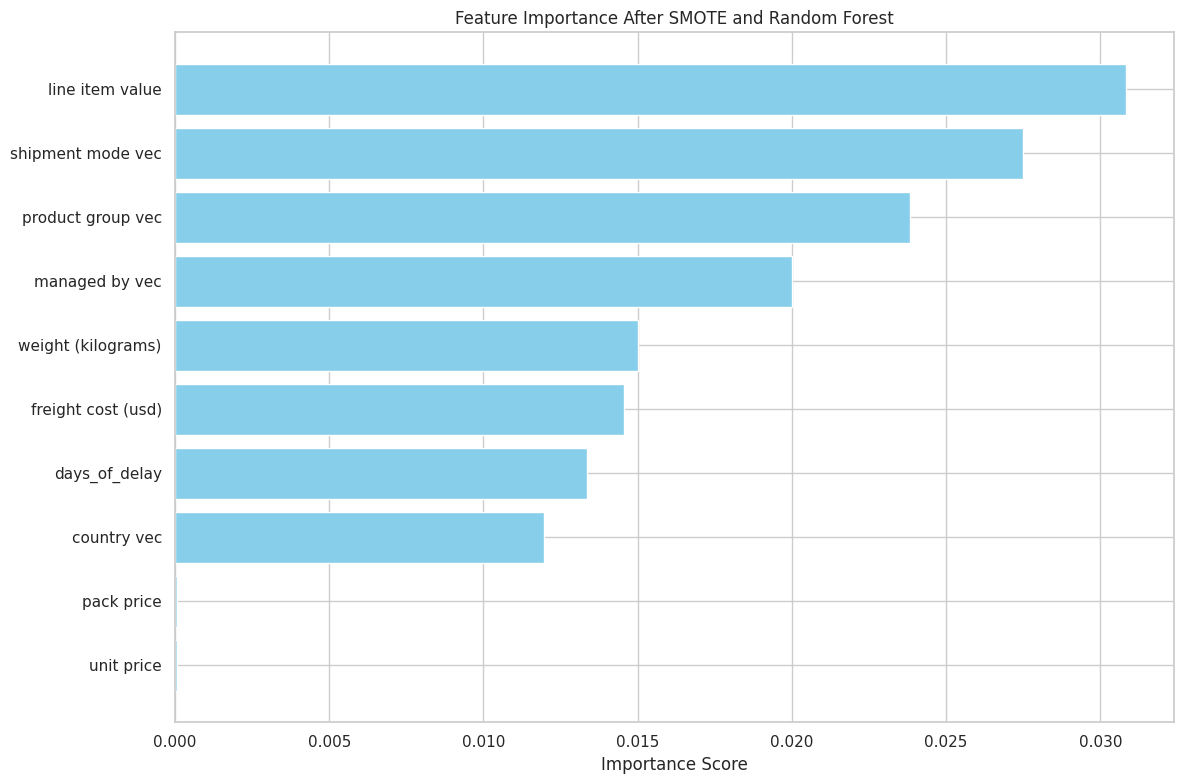

In [29]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# duplicated data so that original dataframe is not affected
processed_data = data

# data preprocessing for modelling
categorical_features = ["shipment mode", "product group", "country", "managed by"]
numerical_features = ["weight (kilograms)", "freight cost (usd)", "pack price", "unit price", "line item value", "days_of_delay"]

# Indexing and One-Hot Encode categorical features
indexers = [StringIndexer(inputCol=col, outputCol=f"{col} index") for col in categorical_features]
encoders = [OneHotEncoder(inputCol=f"{col} index", outputCol=f"{col} vec") for col in categorical_features]

# assembling all features
assembler = VectorAssembler(
    inputCols=[f"{col} vec" for col in categorical_features] + numerical_features,
    outputCol="features"
)

# preprocessing pipeline
preprocessing_pipeline = Pipeline(stages=indexers + encoders + [assembler])
processed_data = preprocessing_pipeline.fit(processed_data).transform(processed_data)

# Index the target column
label_indexer = StringIndexer(inputCol="delay_category", outputCol="delay_category_index")
processed_data = label_indexer.fit(processed_data).transform(processed_data)

# extracting features and target from Spark DataFrame
X = np.array(processed_data.select("features").rdd.map(lambda row: row[0].toArray()).collect())
y = np.array(processed_data.select("delay_category_index").rdd.map(lambda row: row[0]).collect())

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# applying SMOTE to balance class distribution
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Random Forest Classifier with Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# best parameters
print("Best Hyperparameters:", grid_search.best_params_)

# train the best model
best_rf = grid_search.best_estimator_
best_rf.fit(X_train_resampled, y_train_resampled)

# model evaluation
y_pred = best_rf.predict(X_test)

# evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature Importance Visualization
feature_importances = best_rf.feature_importances_
features = [f"{col} vec" for col in categorical_features] + numerical_features

# sorting feature importance scores
importance_scores = list(zip(features, feature_importances))
importance_scores_sorted = sorted(importance_scores, key=lambda x: x[1], reverse=True)

# plot feature importances
sorted_features, sorted_scores = zip(*importance_scores_sorted)
plt.figure(figsize=(12, 8))
plt.barh(sorted_features, sorted_scores, color="skyblue")
plt.xlabel("Importance Score")
plt.title("Feature Importance After SMOTE and Random Forest")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [30]:
from collections import Counter
print("Original class distribution:", Counter(y_train))
print("Resampled class distribution:", Counter(y_train_resampled))

Original class distribution: Counter({0.0: 5253, 1.0: 1373, 2.0: 446, 3.0: 154})
Resampled class distribution: Counter({0.0: 5253, 1.0: 5253, 3.0: 5253, 2.0: 5253})


Linear Regression Model

Mean Absolute Error: 13.840999291866666
Mean Squared Error: 699.0595958927859
R^2 Score: 0.07116113087461717


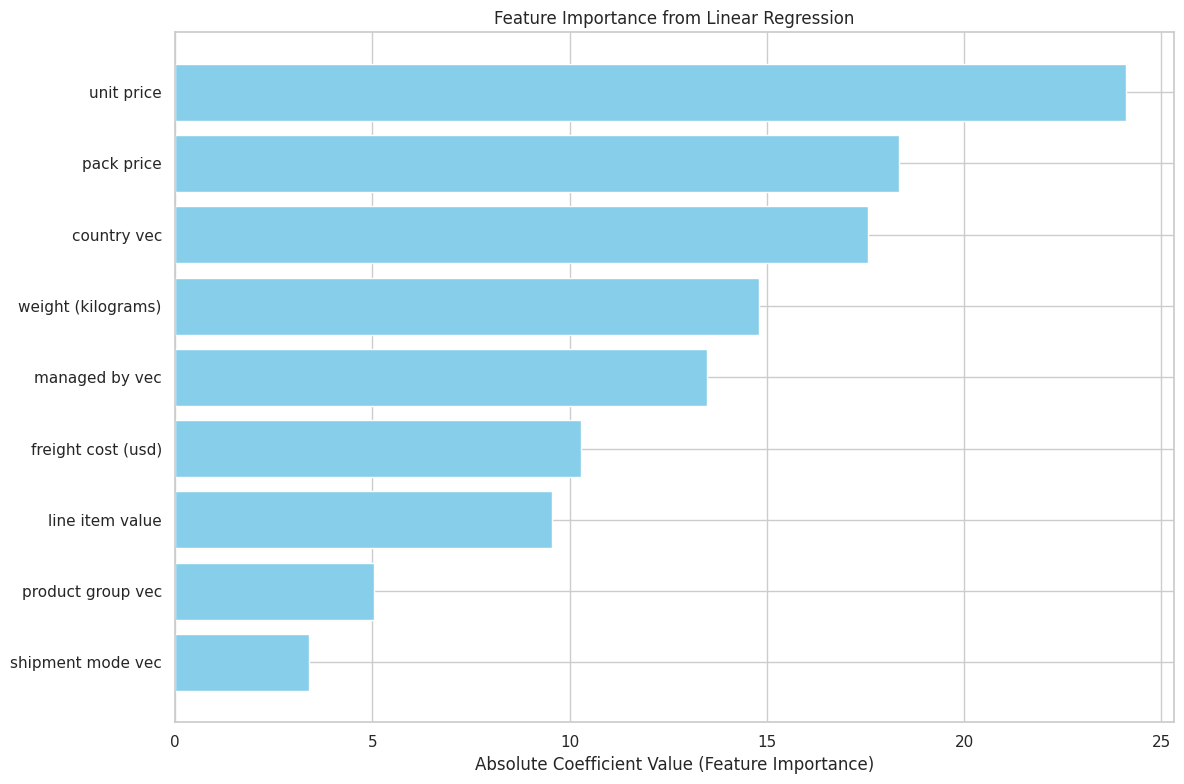

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Duplicate data for linear regression
processed_data_lm = data

# Step 1: Data Preprocessing
categorical_features_lm = ["shipment mode", "product group", "country", "managed by"]
numerical_features_lm = ["weight (kilograms)", "freight cost (usd)", "pack price", "unit price", "line item value"]

# Index and One-Hot Encode categorical features
indexers_lm = [StringIndexer(inputCol=col, outputCol=f"{col} index") for col in categorical_features_lm]
encoders_lm = [OneHotEncoder(inputCol=f"{col} index", outputCol=f"{col} vec") for col in categorical_features_lm]

# Assemble all features
assembler_lm = VectorAssembler(
    inputCols=[f"{col} vec" for col in categorical_features_lm] + numerical_features_lm,
    outputCol="features"
)

# Preprocessing pipeline
preprocessing_pipeline_lm = Pipeline(stages=indexers_lm + encoders_lm + [assembler_lm])
processed_data_lm = preprocessing_pipeline_lm.fit(processed_data_lm).transform(processed_data_lm)

# Step 2: Extract features and target
X = np.array(processed_data_lm.select("features").rdd.map(lambda row: row[0].toArray()).collect())
y = np.array(processed_data_lm.select("days_of_delay").rdd.map(lambda row: row[0]).collect())

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Train Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Step 5: Model Evaluation
y_pred = lin_reg.predict(X_test)
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))

# Step 6: Feature Importance
feature_importances = lin_reg.coef_  # Coefficients represent feature importance
features = [f"{col} vec" for col in categorical_features_lm] + numerical_features_lm

# Pairing features with their importance and sorting
importance_scores = list(zip(features, feature_importances))
importance_scores_sorted = sorted(importance_scores, key=lambda x: abs(x[1]), reverse=True)

# Step 7: Plotting Feature Importances
sorted_features, sorted_importances = zip(*importance_scores_sorted)
plt.figure(figsize=(12, 8))
plt.barh(sorted_features, np.abs(sorted_importances), color="skyblue")  # Use absolute values for visualization
plt.xlabel("Absolute Coefficient Value (Feature Importance)")
plt.title("Feature Importance from Linear Regression")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Across all delay categories, the Random Forest Classifier showed remarkable performance, attaining an **accuracy of 99.58%** with nearly flawless precision, recall, and F1-scores. Its confusion matrix shows few misclassifications, demonstrating how well the model manages intricate feature interactions and class imbalances. Random Forest demonstrated a high degree of suitability for categorical prediction tasks that demand high accuracy and robustness through balanced class weights and hyperparameter adjustment. The Linear Regression model, on the other hand, did not perform well; its low **R2 score of 0.07** meant that the features only explained **7%** of the variance in delivery delay. For this dataset, high error measures such as **Mean Squared Error (699.06) and Mean Absolute Error (13.84)** indicate that a linear relationship assumption is not enough.